In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [7]:
tf.__version__

'2.15.0'

In [8]:
img_size=(256,256)
Batch_Size=32
train_path="/content/drive/MyDrive/Potato_Dataset/Training"
valid_path="/content/drive/MyDrive/Potato_Dataset/Validation"
dataset_path="/content/drive/MyDrive/Potato_Dataset"

In [9]:
!nvidia-smi

Wed Apr 10 17:20:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [10]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
   train_path,
    shuffle=True,
    image_size=img_size,
    batch_size=Batch_Size
)


Found 1533 files belonging to 2 classes.


In [11]:
class_names=dataset.class_names
class_names

['Healthy', 'Late_Blight']

In [12]:
len(dataset)

48

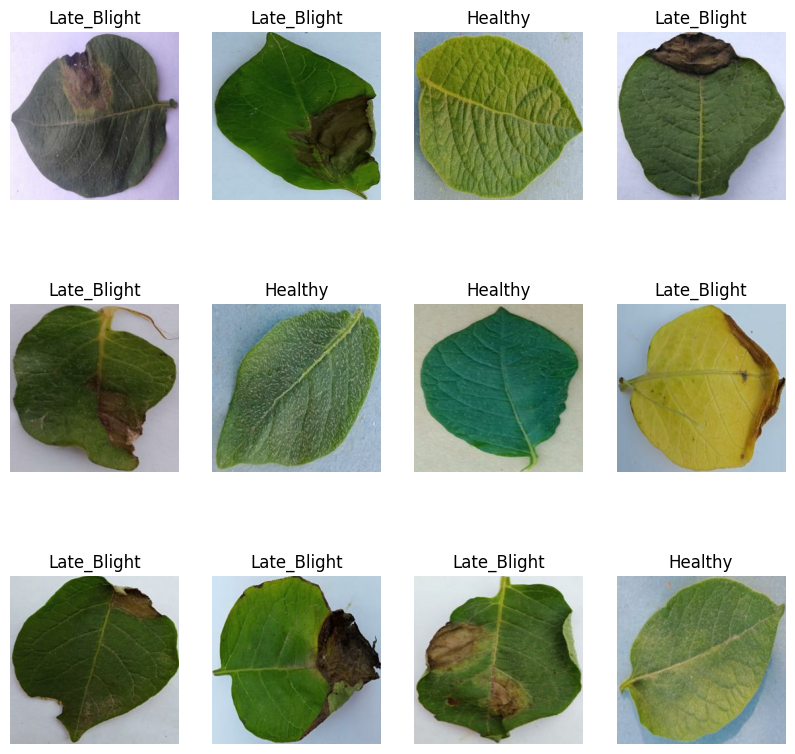

In [13]:
plt.figure(figsize=(10,10))

for image_batch,label_batch in dataset.take(1):
  for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")


In [14]:
len(dataset)

48

In [15]:
train_size=0.8
len(dataset)*train_size

38.400000000000006

In [16]:
train_dataset=dataset.take(38)
len(train_dataset)

38

In [17]:
x=dataset.skip(38)
len(x)

10

In [18]:
val_size=0.1
len(dataset)*val_size
val_dataset=x.take(4)

In [19]:
y=x.skip(4)
test_datset=y.take(6)
len(y)

6

In [20]:
def get_dataset_partition_tf(dataset,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
  ds_size=len(dataset)
  if shuffle:
    dataset=dataset.shuffle(shuffle_size,seed=120)
  train_size=int(train_split*ds_size)
  val_size=int(val_split*ds_size)
  test_size=int(test_split*ds_size)

  train_dataset=dataset.take(train_size)
  val_dataset=dataset.skip(train_size).take(val_size)
  test_dataset=dataset.skip(train_size).skip(val_size)


  return train_dataset,val_dataset,test_dataset

In [21]:
train_dataset,val_dataset,test_dataset=get_dataset_partition_tf(dataset)

In [22]:
len(train_dataset)

38

In [23]:
train_dataset=train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset=test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255),

])

In [25]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [26]:
input_shape=(Batch_Size,256,256,3)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(2,2),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 126, 126, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 63, 63, 64)          0         
 g2D)                                                 

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [29]:
history=model.fit(
    train_dataset,
    epochs=100,
    batch_size=Batch_Size,
    verbose=1,
    validation_data=val_dataset
)

Epoch 1/100
38/38 [==============================] - 136s 227ms/step - loss: 0.7316 - accuracy: 0.7832 - val_loss: 0.3249 - val_accuracy: 0.9062
Epoch 2/100
38/38 [==============================] - 2s 54ms/step - loss: 0.2495 - accuracy: 0.9250 - val_loss: 0.2916 - val_accuracy: 0.9141
Epoch 3/100
38/38 [==============================] - 2s 53ms/step - loss: 0.2094 - accuracy: 0.9340 - val_loss: 0.2329 - val_accuracy: 0.9141
Epoch 4/100
38/38 [==============================] - 2s 53ms/step - loss: 0.1928 - accuracy: 0.9382 - val_loss: 0.2075 - val_accuracy: 0.9297
Epoch 5/100
38/38 [==============================] - 2s 57ms/step - loss: 0.1668 - accuracy: 0.9481 - val_loss: 0.1415 - val_accuracy: 0.9297
Epoch 6/100
38/38 [==============================] - 2s 55ms/step - loss: 0.1689 - accuracy: 0.9456 - val_loss: 0.1649 - val_accuracy: 0.9375
Epoch 7/100
38/38 [==============================] - 2s 52ms/step - loss: 0.1404 - accuracy: 0.9588 - val_loss: 0.1447 - val_accuracy: 0.9453
Epo

In [30]:
scores=model.evaluate(test_dataset)

6/6 [==============================] - 5s 20ms/step - loss: 0.0082 - accuracy: 1.0000


In [31]:
scores

[0.00823607761412859, 1.0]

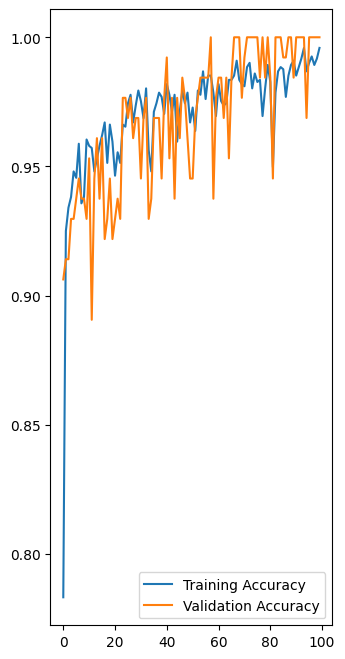

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(100),history.history['accuracy'],label='Training Accuracy')
plt.plot(range(100),history.history['val_accuracy'],label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

first image to predict
First image's actual label: Late_Blight
1/1 [==============================] - 0s 30ms/step
First image's predicted label: Late_Blight


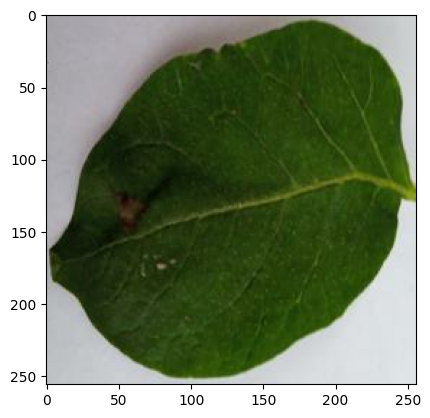

In [41]:
import numpy as np
for images_batch,label_batch in test_dataset.take(1):
  first_image=images_batch[0].numpy().astype('uint8')
  first_label=label_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("First image's actual label:",class_names[first_label])

  batch_prediction=model.predict(images_batch)
  pred_label=np.argmax(batch_prediction[0])
  print("First image's predicted label:",class_names[pred_label])